## Goal:  Optimize Porfolio. Define Optimal Risky Portfolio

In [1]:
#### https://www.machinelearningplus.com/machine-learning/portfolio-optimization-python-example/

<br> 1. Reading in desirable list of stocks from previously done algorythm (in this case by clustering + least correlated)
<br> 2*. *Reading in N-day forecast forcast_X.h5, Current Portfolio portfolio_X.h5, reading in Historical Price data*
<br> 3. Using Efficient frontier for optimizing Portfolio. Saving it into qsoptimizer_X.py
<br> 4. Using Sharpe ratio for choosing Optimal Risky Portfolio
<br> 5. Saving it as TargetPortfolio_X.h5

We used:
- Clustering tecknique  on all tickers and choosing one from each cluster representative with larger market cap
- Paired each choosen represantative stock with the least correlated stock from SP500 to balance out the Portfolio
<br> => ['VZ', 'TSLA', 'INTC', 'CAT', 'JNJ', 'PFE', 'AAPL', 'MSFT']

This notebook goal:
- find the best weights for each stock in this list for the Optimal risk portfolio using Efficient Frontier and Sharpe Ratio

The total expected return for a portfolio is given by:

𝐸(𝑅𝑝)=𝑤1𝐸(𝑅1)+𝑤2𝐸(𝑅2)+…..𝑤𝑛𝐸(𝑅𝑛)
<br> Thus, e_r, or total expected return can be calculated as:

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
import pickle


from sklearn.cluster import KMeans
from math import sqrt
import  pylab as pl
import sys, os

# enable pandas to show all the column
pd.set_option('display.max_columns', 500)

In [6]:
['VZ', 'TSLA', 'INTC', 'CAT', 'JNJ', 'PFE', 'AAPL', 'MSFT']

['VZ', 'TSLA', 'INTC', 'CAT', 'JNJ', 'PFE', 'AAPL', 'MSFT']

### Read/prepare  data

In [7]:
df = pd.read_pickle('data/raw_data.pkl')

In [18]:
stocks_choice = ['VZ', 'TSLA', 'INTC', 'CAT', 'JNJ', 'PFE', 'AAPL', 'MSFT']
df = df[df.ticker.isin(stocks_choice)]
df.head()

,ticker,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,assetsnc,assetturnover,bvps,capex,cashneq,cashnequsd,cor,consolinc,currentratio,de,debt,debtc,debtnc,debtusd,deferredrev,depamor,deposits,divyield,dps,ebit,ebitda,ebitdamargin,ebitdausd,ebitusd,ebt,eps,epsdil,epsusd,equity,equityavg,equityusd,ev,evebit,evebitda,fcf,fcfps,fxusd,gp,grossmargin,intangibles,intexp,invcap,invcapavg,inventory,investments,investmentsc,investmentsnc,liabilities,liabilitiesc,liabilitiesnc,marketcap,ncf,ncfbus,ncfcommon,ncfdebt,ncfdiv,ncff,ncfi,ncfinv,ncfo,ncfx,netinc,netinccmn,netinccmnusd,netincdis,netincnci,netmargin,opex,opinc,payables,payoutratio,pb,pe,pe1,ppnenet,prefdivis,price,ps,ps1,receivables,retearn,revenue,revenueusd,rnd,roa,roe,roic,ros,sbcomp,sgna,sharefactor,sharesbas,shareswa,shareswadil,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,Open,High,Low,Close,Adj Close,Volume
54356,MSFT,MRY,2011-12-31,2011-06-30,2011-06-30,2022-01-25,0.0,1.087040e+11,9.806925e+10,7.491800e+10,3.378600e+10,0.713,6.724,-2.355000e+09,5.277200e+10,5.277200e+10,1.557700e+10,2.315000e+10,2.604,0.904,1.192100e+10,0.0,1.192100e+10,1.192100e+10,1.712000e+10,2.766000e+09,0.0,0.023,0.61,2.836600e+10,3.113200e+10,0.445,3.113200e+10,2.836600e+10,2.807100e+10,2.73,2.69,2.73,5.708300e+10,5.148950e+10,5.708300e+10,1.810169e+11,6.0,5.814,2.463900e+10,2.902,1.0,5.436600e+10,0.777,1.332500e+10,295000000.0,2.575400e+10,2.283900e+10,1.372000e+09,1.086500e+10,0.0,1.086500e+10,5.162100e+10,2.877400e+10,2.284700e+10,2.192519e+11,4.105000e+09,-71000000.0,-9.133000e+09,5.960000e+09,-5.180000e+09,-8.376000e+09,-1.461600e+10,-1.321600e+10,2.699400e+10,103000000.0,2.315000e+10,2.315000e+10,2.315000e+10,0.0,0.0,0.331,2.720500e+10,2.716100e+10,5.405000e+09,0.223,3.841,9.471,9.524,8.162000e+09,0.0,26.0,3.135,3.156,1.498700e+10,-6.332000e+09,6.994300e+10,6.994300e+10,9.043000e+09,0.236,0.45,1.242,0.406,2.149000e+09,1.816200e+10,1.0,8.432767e+09,8.490000e+09,8.593000e+09,8.238,9.537900e+10,2.467000e+09,4.921000e+09,2.036000e+09,11.234,4.614400e+10,25.740000,26.000000,25.660000,26.000000,20.713480,52535400.0
54355,MSFT,MRY,2011-12-31,2011-06-30,2011-07-01,2022-01-25,0.0,1.087040e+11,9.806925e+10,7.491800e+10,3.378600e+10,0.713,6.724,-2.355000e+09,5.277200e+10,5.277200e+10,1.557700e+10,2.315000e+10,2.604,0.904,1.192100e+10,0.0,1.192100e+10,1.192100e+10,1.712000e+10,2.766000e+09,0.0,0.023,0.61,2.836600e+10,3.113200e+10,0.445,3.113200e+10,2.836600e+10,2.807100e+10,2.73,2.69,2.73,5.708300e+10,5.148950e+10,5.708300e+10,1.810169e+11,6.0,5.814,2.463900e+10,2.902,1.0,5.436600e+10,0.777,1.332500e+10,295000000.0,2.575400e+10,2.283900e+10,1.372000e+09,1.086500e+10,0.0,1.086500e+10,5.162100e+10,2.877400e+10,2.284700e+10,2.192519e+11,4.105000e+09,-71000000.0,-9.133000e+09,5.960000e+09,-5.180000e+09,-8.376000e+09,-1.461600e+10,-1.321600e+10,2.699400e+10,103000000.0,2.315000e+10,2.315000e+10,2.315000e+10,0.0,0.0,0.331,2.720500e+10,2.716100e+10,5.405000e+09,0.223,3.841,9.471,9.524,8.162000e+09,0.0,26.0,3.135,3.156,1.498700e+10,-6.332000e+09,6.994300e+10,6.994300e+10,9.043000e+09,0.236,0.45,1.242,0.406,2.149000e+09,1.816200e+10,1.0,8.432767e+09,8.490000e+09,8.593000e+09,8.238,9.537900e+10,2.467000e+09,4.921000e+09,2.036000e+09,11.234,4.614400e+10,25.930000,26.170000,25.840000,26.020000,20.729414,52906200.0
54354,MSFT,MRY,2011-12-31,2011-06-30,2011-07-05,2022-01-25,0.0,1.087040e+11,9.806925e+10,7.491800e+10,3.378600e+10,0.713,6.724,-2.355000e+09,5.277200e+10,5.277200e+10,1.557700e+10,2.315000e+10,2.604,0.904,1.192100e+10,0.0,1.192100e+10,1.192100e+10,1.712000e+10,2.766000e+09,0.0,0.023,0.61,2.836600e+10,3.113200e+10,0.445,3.113200e+10,2.836600e+10,2.807100e+10,2.73,2.69,2.73,5.708300e+10,5.148950e+10,5.708300e+10,1.810169e+11,6.0,5.814,2.463900e+10,2.902,1.0,5.436600e+10,0.777,1.332500e+10,295000000.0,2.575400e+10,2.283900e+10,1.372000e+09,1.086500e+10,0.0,1.086500e+10,5.162100e+10,2.877400e+10,2.284700e+10,2.192519e+11,4.105000e+09,-71000000.0,-9

In [22]:
df = pd.pivot_table(df, values='Adj Close', index=['reportperiod'], columns=['ticker'])
df

ticker,AAPL,CAT,INTC,JNJ,MSFT,PFE,TSLA,VZ
reportperiod,,,,,,,,
2011-06-30,NaN,NaN,NaN,NaN,20.713480,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN,20.729414,NaN,NaN,NaN
2011-07-05,NaN,NaN,NaN,NaN,20.737383,NaN,NaN,NaN
2011-07-06,NaN,NaN,NaN,NaN,20.976383,NaN,NaN,NaN
2011-07-07,NaN,NaN,NaN,NaN,21.326921,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-03-15,155.089996,216.460007,44.810001,176.139999,287.149994,52.209999,801.890015,52.759998
2022-03-16,159.589996,216.080002,46.630001,174.520004,294.390015,52.919998,840.229980,52.490002
2022-03-17,160.619995,221.699997,47.139999,176.800003,295.220001,54.240002,871.599976,52.360001


In [23]:
df.isnull().sum() 

ticker
AAPL     60
CAT     128
INTC    128
JNJ     128
MSFT      0
PFE     128
TSLA    128
VZ      128
dtype: int64

In [24]:
df.shape

(2699, 8)

In [28]:
df = df.dropna(axis=0)

In [30]:
df.shape

(2571, 8)

In [43]:
# Log of Percentage change daily
relative_returns = df.pct_change().apply(lambda x: np.log(1+x))

In [44]:
# calculating relative individual stock return daily
expected_return_individual = relative_returns.mean() 
expected_return_individual

ticker
AAPL    0.001003
CAT     0.000449
INTC    0.000373
JNJ     0.000494
MSFT    0.001022
PFE     0.000523
TSLA    0.001984
VZ      0.000277
dtype: float64

In [45]:
#choosing random weights for the start allocation
weights = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
# calculating total daily portfolio return with random assets share allocation
expected_daily_portfolio_return = (expected_return_individual*weights).sum()
expected_daily_portfolio_return

0.0007658059992253402

In [46]:
# Yearly returns for individual companies
yearly_expected_return_individual = df.resample('Y').last().pct_change().mean()
yearly_expected_return_individual

ticker
AAPL    0.300399
CAT     0.154671
INTC    0.131570
JNJ     0.129651
MSFT    0.312862
PFE     0.140754
TSLA    1.247586
VZ      0.063283
dtype: float64

In [47]:
# choosing random weights for the start allocation
weights = [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]
#Portfolio yearly return
total_port_return = (weights*yearly_expected_return_individual).sum()
total_port_return

0.3100971113964782

## Building an optimal risky portfolio

In [51]:
# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
ann_std = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_std

ticker
AAPL    0.283336
CAT     0.277039
INTC    0.292846
JNJ     0.171013
MSFT    0.255844
PFE     0.207973
TSLA    0.555730
VZ      0.171962
dtype: float64

In [54]:
# Creating a table for visualising returns and volatility of assets
assets = pd.concat([yearly_expected_return_individual, ann_std], axis=1) 
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
ticker,,
AAPL,0.300399,0.283336
CAT,0.154671,0.277039
INTC,0.131570,0.292846
JNJ,0.129651,0.171013
MSFT,0.312862,0.255844
PFE,0.140754,0.207973
TSLA,1.247586,0.555730
VZ,0.063283,0.171962


#### => TSLA has the highest return, but risk attached to it also the highest.
#### Apple lies somewhere in the middle, with average risk and return rates.


### Plotting the efficient frontier


In [80]:
# Log of percentage change
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

ticker,AAPL,CAT,INTC,JNJ,MSFT,PFE,TSLA,VZ
ticker,,,,,,,,
AAPL,0.000321,0.000116,0.000154,0.000065,0.000166,0.000068,0.000210,0.000044
CAT,0.000116,0.000307,0.000142,0.000072,0.000118,0.000075,0.000127,0.000060
INTC,0.000154,0.000142,0.000343,0.000074,0.000172,0.000080,0.000190,0.000061
JNJ,0.000065,0.000072,0.000074,0.000117,0.000075,0.000077,0.000055,0.000055
MSFT,0.000166,0.000118,0.000172,0.000075,0.000262,0.000076,0.000198,0.000057
PFE,0.000068,0.000075,0.000080,0.000077,0.000076,0.000173,0.000061,0.000054
TSLA,0.000210,0.000127,0.000190,0.000055,0.000198,0.000061,0.001235,0.000033
VZ,0.000044,0.000060,0.000061,0.000055,0.000057,0.000054,0.000033,0.000118


In [81]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df.columns)
num_portfolios = 10000

In [82]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, yearly_expected_return_individual) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    std = np.sqrt(var) # Daily standard deviation
    ann_std = std*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_std)
    
    

In [83]:
df.columns.tolist()

['AAPL', 'CAT', 'INTC', 'JNJ', 'MSFT', 'PFE', 'TSLA', 'VZ']

In [84]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [85]:
len(p_ret),len(p_vol)

(10000, 10000)

In [86]:
portfolios  = pd.DataFrame(data)
#portfolios.head() # Dataframe of the 10000 portfolios created


<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

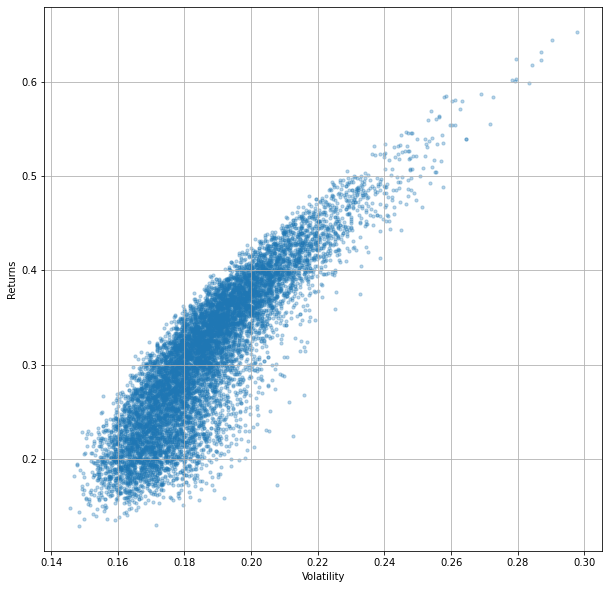

In [87]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])

In [89]:
# the least risky Portfolio
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]                              
min_vol_port

Returns        0.147542
Volatility     0.145526
AAPL weight    0.106513
CAT weight     0.058502
INTC weight    0.051967
JNJ weight     0.303411
MSFT weight    0.085786
PFE weight     0.106996
TSLA weight    0.000229
VZ weight      0.286596
Name: 5070, dtype: float64

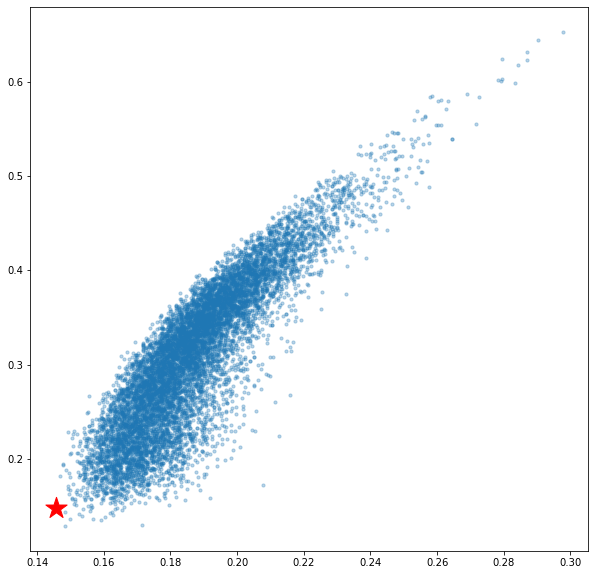

In [90]:
# plotting the minimum volatility portfolio
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)


## Optimal Risky Portfolio

In [91]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns        0.583841
Volatility     0.257900
AAPL weight    0.134573
CAT weight     0.012782
INTC weight    0.011912
JNJ weight     0.222092
MSFT weight    0.162385
PFE weight     0.008344
TSLA weight    0.363718
VZ weight      0.084194
Name: 3014, dtype: float64

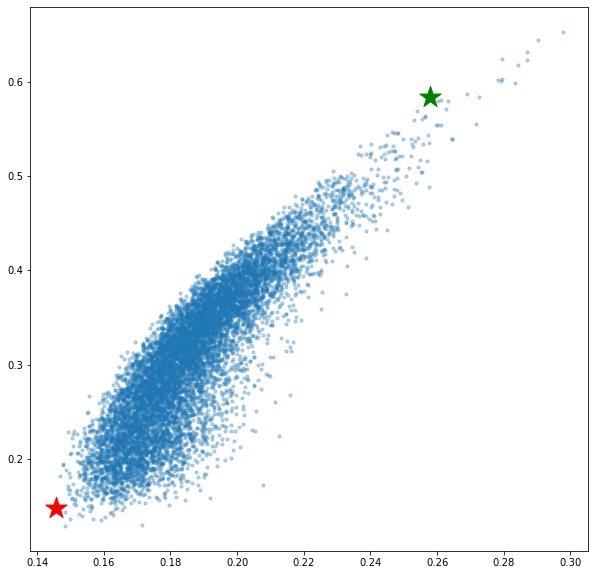

In [92]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)


## SO we found our Optimal Risky portfolio , given our choosen stock list:

In [93]:
optimal_risky_port

Returns        0.583841
Volatility     0.257900
AAPL weight    0.134573
CAT weight     0.012782
INTC weight    0.011912
JNJ weight     0.222092
MSFT weight    0.162385
PFE weight     0.008344
TSLA weight    0.363718
VZ weight      0.084194
Name: 3014, dtype: float64

In [96]:
type(optimal_risky_port)

pandas.core.series.Series

In [94]:
parentDirectory = os.getcwd()

In [98]:
optimal_risky_port.to_hdf(parentDirectory + '/data/TargetPortfolio_X.h5',key='str')

In [100]:
optimal_risky_port = pd.read_hdf(parentDirectory + '/data/TargetPortfolio_X.h5')

In [102]:
type(optimal_risky_port)

pandas.core.series.Series

In [103]:
optimal_risky_port

Returns        0.583841
Volatility     0.257900
AAPL weight    0.134573
CAT weight     0.012782
INTC weight    0.011912
JNJ weight     0.222092
MSFT weight    0.162385
PFE weight     0.008344
TSLA weight    0.363718
VZ weight      0.084194
Name: 3014, dtype: float64